<img src="https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png" alt="InvertedAI" width="200"/>


# General Demo
This demo will showcase some of the capabilities available in the Inverted AI API, including INITIALIZE and DRIVE

In [1]:
# Some stuff to get us going:
!pip install -I --upgrade invertedai
from IPython.display import clear_output
clear_output()

In [ ]:
import os
os.kill(os.getpid(), 9) # Runtime needs to be restarted after updating packages

In [1]:
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai
from IPython.utils import io
import time

In [2]:
#API key:
iai.add_apikey("wL5lK344fS2swKeP3x2FT2nGm3PGqBKWawDEp1Sk")

## Setup

We begin by setting up the simulation and previewing some of the environment. We pick a location, a four way signalized intersection.

In [3]:
location = "canada:drake_street_and_pacific_blvd"
#location = "canada:marine_drive_viewpoint_3"

SIMULATION_LENGTH = 50
RENDERING_FOV = 130
FIGURE_SIZE = 10
AGENT_COUNT = 10
GIF_RATIO = 1.33
GIF_SIZE = 100*FIGURE_SIZE

## Preview map location

We can preview the map, and look at the traffic light locations to understand which of the lights control which road

(None, <matplotlib.image.AxesImage at 0x7c961b365f10>)

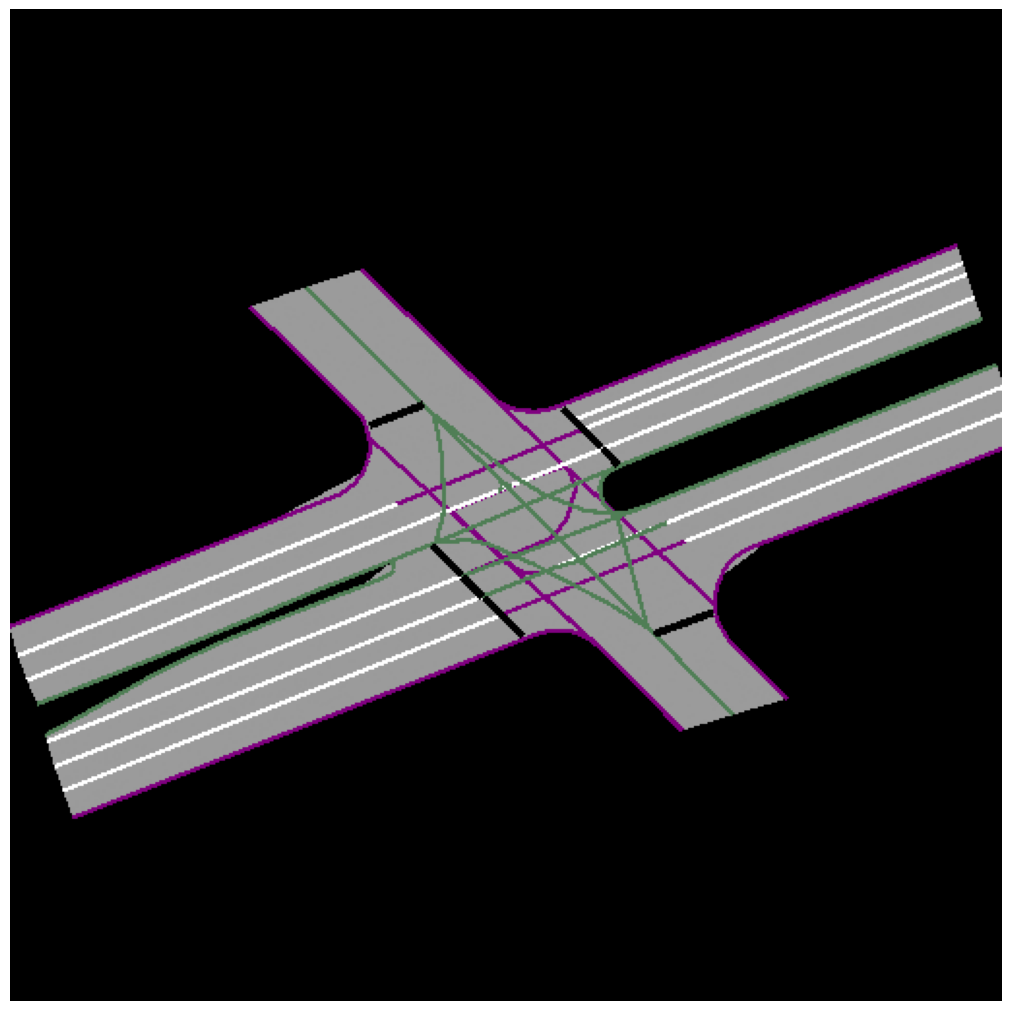

In [4]:
location_info = iai.location_info(location=location,rendering_fov=RENDERING_FOV)
rendered_static_map = location_info.birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_static_map)

We initialize the client side plotting code, this class is helpful for constructing single time plots, and animated gifs:

In [5]:
scene_plotter = iai.utils.ScenePlotter(rendered_static_map, RENDERING_FOV, (location_info.map_center.x, location_info.map_center.y), location_info.static_actors)

These are the traffic light locations, we can infer from their coordinates which of them control what road, in the following examples we will control them  manually:

In [6]:
for actor in location_info.static_actors:
    print(actor)

actor_id=103760 agent_type='traffic_light' center=Point(x=0.883, y=-15.8905) orientation=0.7876 length=0.3421 width=3.7417 dependant=[103760]
actor_id=103761 agent_type='traffic_light' center=Point(x=-1.682, y=-13.3246) orientation=0.7876 length=0.3423 width=3.3199 dependant=[103761]
actor_id=103762 agent_type='traffic_light' center=Point(x=-4.3522, y=-10.7222) orientation=0.7876 length=0.3419 width=3.8255 dependant=[103762]
actor_id=103763 agent_type='traffic_light' center=Point(x=-7.697, y=-7.3018) orientation=0.7772 length=0.3421 width=5.5475 dependant=[103763]
actor_id=103764 agent_type='traffic_light' center=Point(x=23.2852, y=-15.506) orientation=1.9221 length=0.2903 width=8.218 dependant=[103764]
actor_id=103765 agent_type='traffic_light' center=Point(x=13.688, y=6.3305) orientation=-2.3732 length=0.3171 width=3.2149 dependant=[103765]
actor_id=103766 agent_type='traffic_light' center=Point(x=11.3971, y=8.6804) orientation=-2.3487 length=0.3177 width=3.3191 dependant=[103766]
ac

# Initializing on a controlled intersection

We are now in a position to initialize the simulation, with the above traffic light information, all we need to do is set the traffic lights appropriately. There are two main directions, and a left turn light in one direction. Our initial scenario will be a red light for the main road, and a green light for both side streets. The traffic light states are passed as a dictionary.

In [7]:
main_road_light_state = 'red'
left_turn_light = 'red'
side_road_light_state = 'green'
light_states = [
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    left_turn_light,
    side_road_light_state,
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    side_road_light_state
]
traffic_light = {actor.actor_id : light for actor, light in zip(location_info.static_actors, light_states)}

Now we run INITIALIZE on the plot to setup the scene.

**Note**: to make this demo consistent with its pre-rendered output, we have set the random seed to a fixed number. Removing this argument will randomize the output. We have set the random seed throughout this notebook.

**Note 2**: we separate plotting code and calls to the api as much as possible, to highlight the estimated round trip time. While it is possible to plot results on the fly, this slows the simulation down significantly.

In [8]:
t0 = time.time()
initial_conditions = iai.initialize(
    location,
    agent_attributes = None,
    states_history = None,
    traffic_light_state_history = [traffic_light],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 1
)
t0b = time.time()
print(f'Initialize time: {t0b - t0:.2f} s')

Initialize time: 16.42 s


/usr/local/lib/python3.11/dist-packages/invertedai/utils.py:1012: DeprecationWarning: agent_attributes is deprecated. Please use agent_properties.
  warnings.warn('agent_attributes is deprecated. Please use agent_properties.',category=DeprecationWarning)


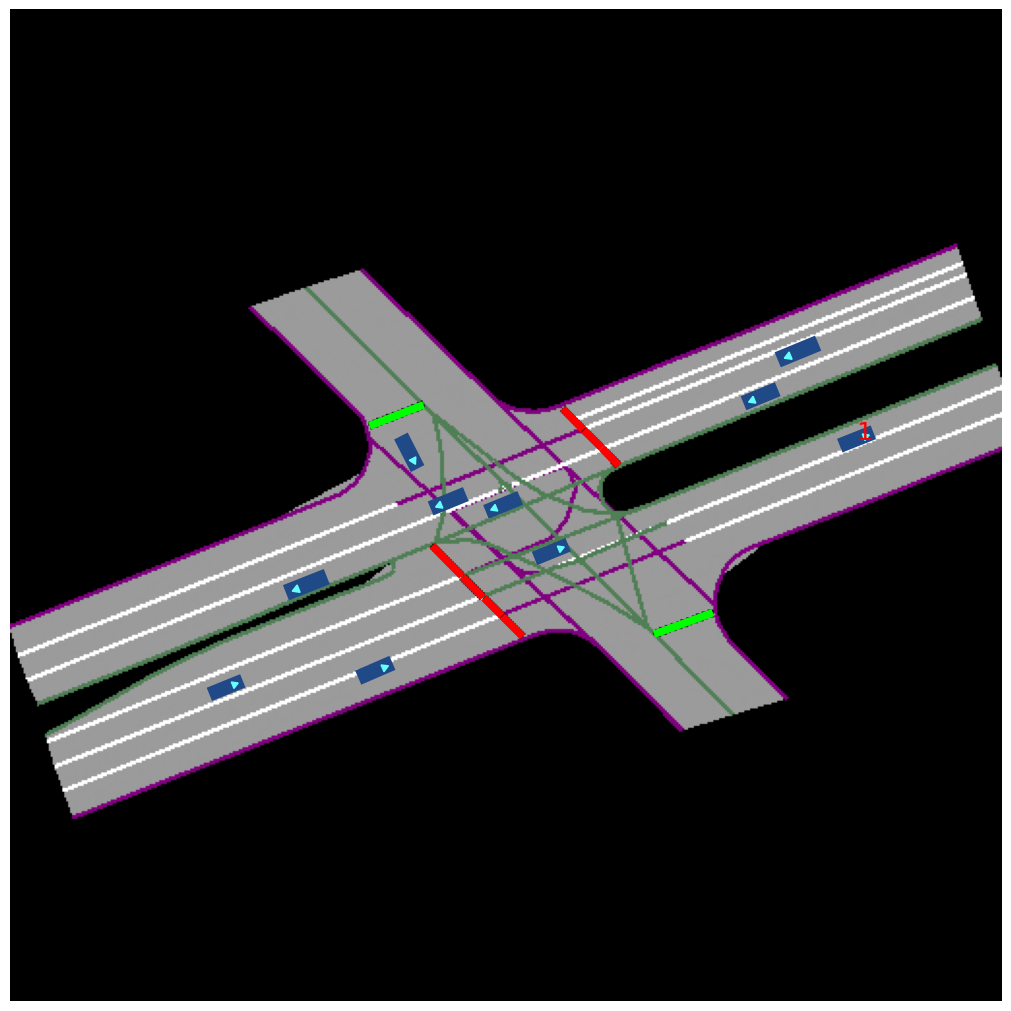

In [11]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    initial_conditions.agent_states,
    initial_conditions.agent_attributes,
    traffic_light_states = traffic_light,
    ax=ax,
    numbers=[True],
    velocity_vec=False,
    direction_vec=True
)

And then we can run DRIVE, conditioned on the traffic light state. For this example, we keep the traffic light fixed over time:

In [12]:
agent_attributes = initial_conditions.agent_attributes
scene_plotter.initialize_recording(initial_conditions.agent_states, agent_attributes=agent_attributes, traffic_light_states=traffic_light)
updated_state = initial_conditions
times = []
for i in range(SIMULATION_LENGTH):
    t0 = time.time()
    print(updated_state)
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        traffic_lights_states=traffic_light,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=traffic_light);
    print(f'Iteration {i}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.53 over 50 calls


Then we assemble a gif:

In [14]:
%%capture
gif_name = 'iai-drive-side-road-green.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=[False],
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

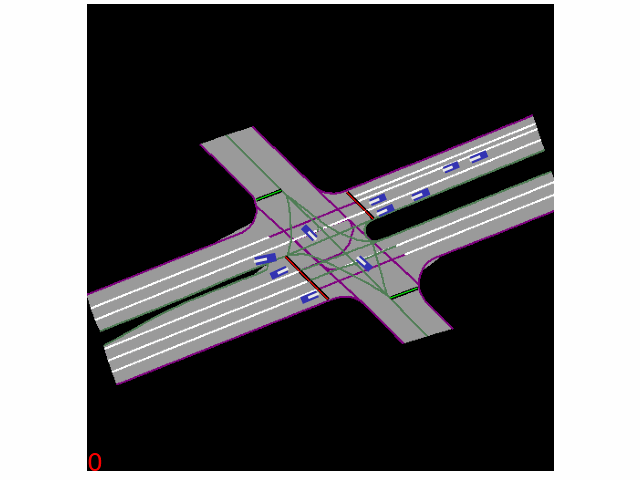

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)

Note how both INITIALIZE and DRIVE correctly obey the set traffic lights: agents stop for red light, and go on green. This is also reflected in the initialized velocities, and positions.

## Alternate traffic light
To demonstrate how the model reacts to different traffic light states, we now show what happens when we initialize with an alternate traffic light state: the main road now has the green light while the side roads are red.

In [ ]:
main_road_light_state = 'green'
left_turn_light = 'green'
side_road_light_state = 'red'
light_states = [
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    left_turn_light,
    side_road_light_state,
    main_road_light_state,
    main_road_light_state,
    main_road_light_state,
    side_road_light_state
]
traffic_light = {actor.actor_id : light for actor, light in zip(location_info.static_actors, light_states)}

We again run INITIALIZE on the new traffic light state dictionary.

In [ ]:
t0 = time.time()
initial_conditions = iai.initialize(
    location,
    agent_attributes = None,
    states_history = None,
    traffic_light_state_history = [traffic_light],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 2
)
t0b = time.time()
print(f'Initialize time: {t0b - t0:.2f} s')

Initialize time: 0.51 s


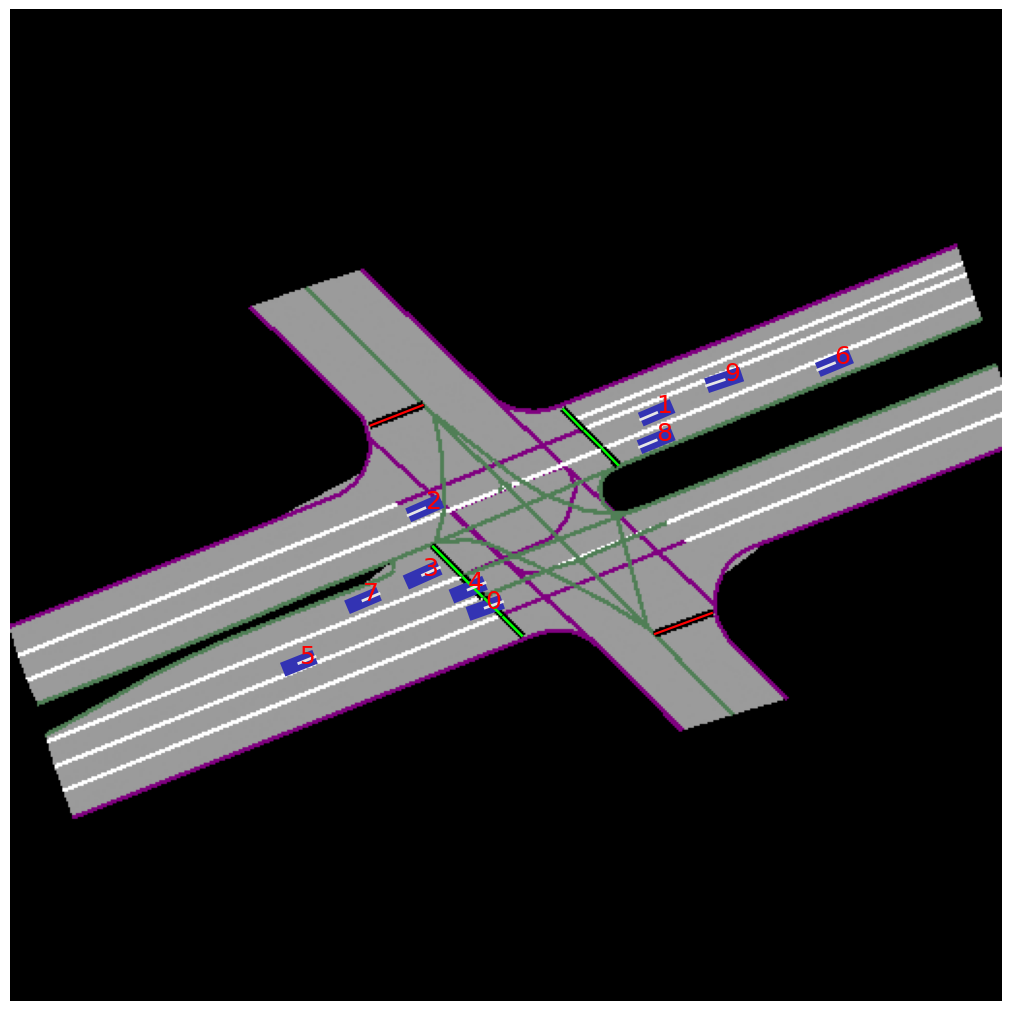

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    initial_conditions.agent_states,
    initial_conditions.agent_attributes,
    traffic_light_states = traffic_light,
    ax=ax,
    numbers=True,
    velocity_vec=False,
    direction_vec=True
)

And simulate using DRIVE:

In [ ]:
agent_attributes = initial_conditions.agent_attributes
scene_plotter.initialize_recording(initial_conditions.agent_states, agent_attributes=agent_attributes, traffic_light_states=traffic_light)
updated_state = initial_conditions;
times = []
for i in range(SIMULATION_LENGTH):
    t0 = time.time()
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        traffic_lights_states=traffic_light,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=traffic_light);
    print(f'Iteration {i}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.02 over 50 calls


Then we assemble a gif:

In [ ]:
%%capture
gif_name = 'iai-drive-side-road-red.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

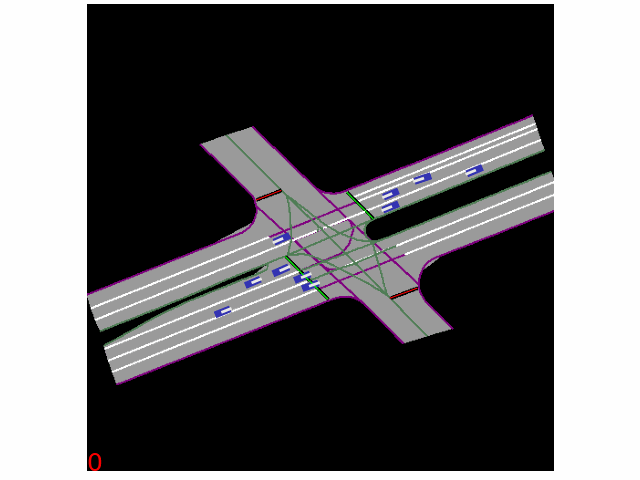

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)

## Conditional (ego) agents

In [ ]:
from invertedai.common import AgentState, AgentAttributes, Point

Suppose we want to simulate a scenario of an ego vehicle taking an unprotected left turn, with a car coming from the oncoming direction. We can set up the ego agent and other agent of interest, and then generate the rest of the scene conditionally using INITIALIZE. We begin by defining the agents of interest (ego and other):

In [ ]:
ego_agent_state = AgentState(center=Point(x=-3.5, y=-6.0), orientation=0.57, speed=0.02)
ego_agent_attributes = AgentAttributes(length=4.9, width=2.05, rear_axis_offset=1.57)

other_agent_state = AgentState(center=Point(x=20, y=9.0), orientation=-2.75, speed=9.57)
other_agent_attributes = AgentAttributes(length=4.68, width=1.95, rear_axis_offset=1.5)

conditional_agent_states = [ego_agent_state, other_agent_state]
conditional_agent_attributes = [ego_agent_attributes, other_agent_attributes]

Note that the speed of our left turning ego agent is close to zero, while the oncoming agent is going almost at full speed. Let's plot the conditional input to INITIALIZE before we make the API call, we use the same traffic lights as in the previous section. We also pass `conditional_agents` to the plotter to give the conditional agents a different color:

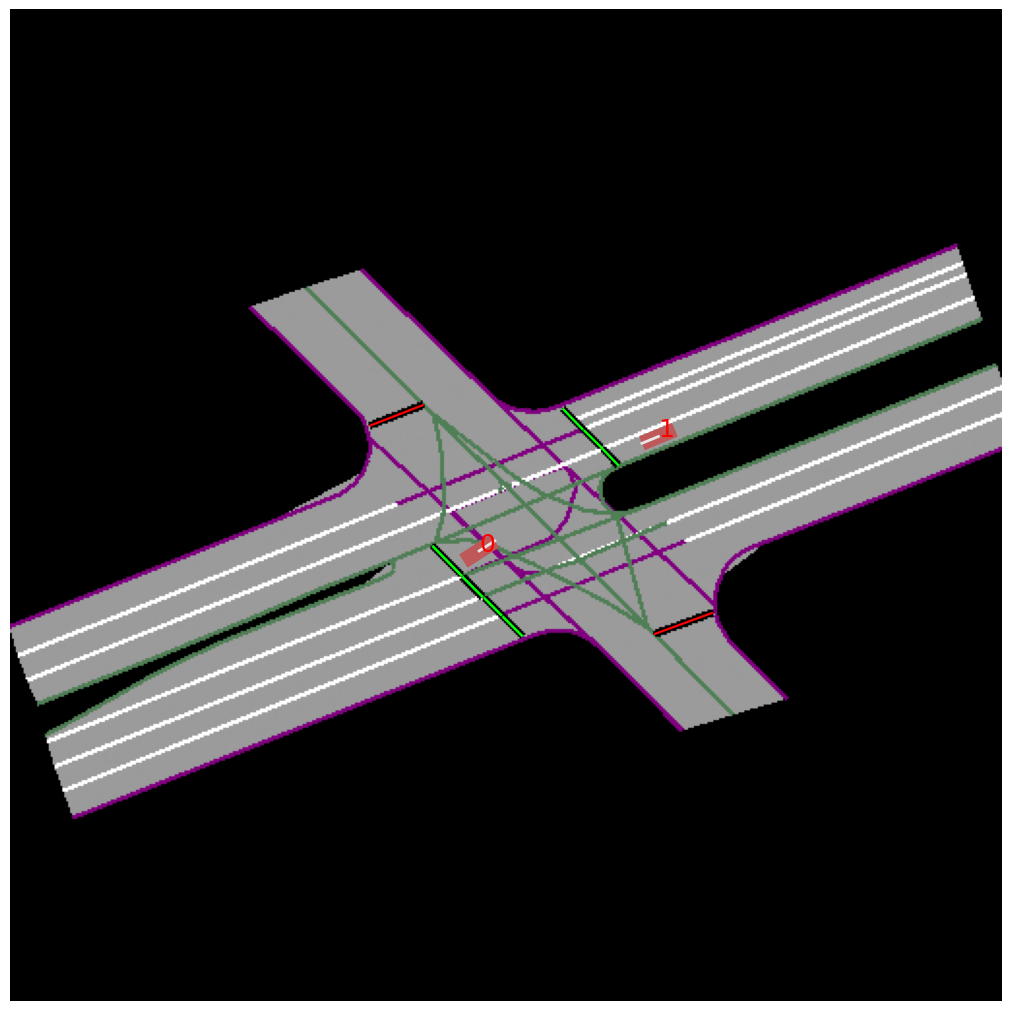

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    conditional_agent_states,
    conditional_agent_attributes,
    traffic_light_states = traffic_light,
    conditional_agents = [0, 1],
    ax=ax,
    numbers=True
)

Then, we initialize _conditionally_ on the agents above, we spawn the remaining agents, and then plot using the scene plotter:

In [ ]:
t0 = time.time()
initial_conditions = iai.initialize(
    location,
    agent_attributes = conditional_agent_attributes,
    states_history = [conditional_agent_states],
    traffic_light_state_history = [traffic_light],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 1
)
t0b = time.time()
print(f'Initialize time: {t0b - t0:.2f} s')


Initialize time: 0.49 s


We plot the resulting initial conditions with an extra keyword argument `velocity_vec`, which draws a vector in green, proportional to the speed of the agent.

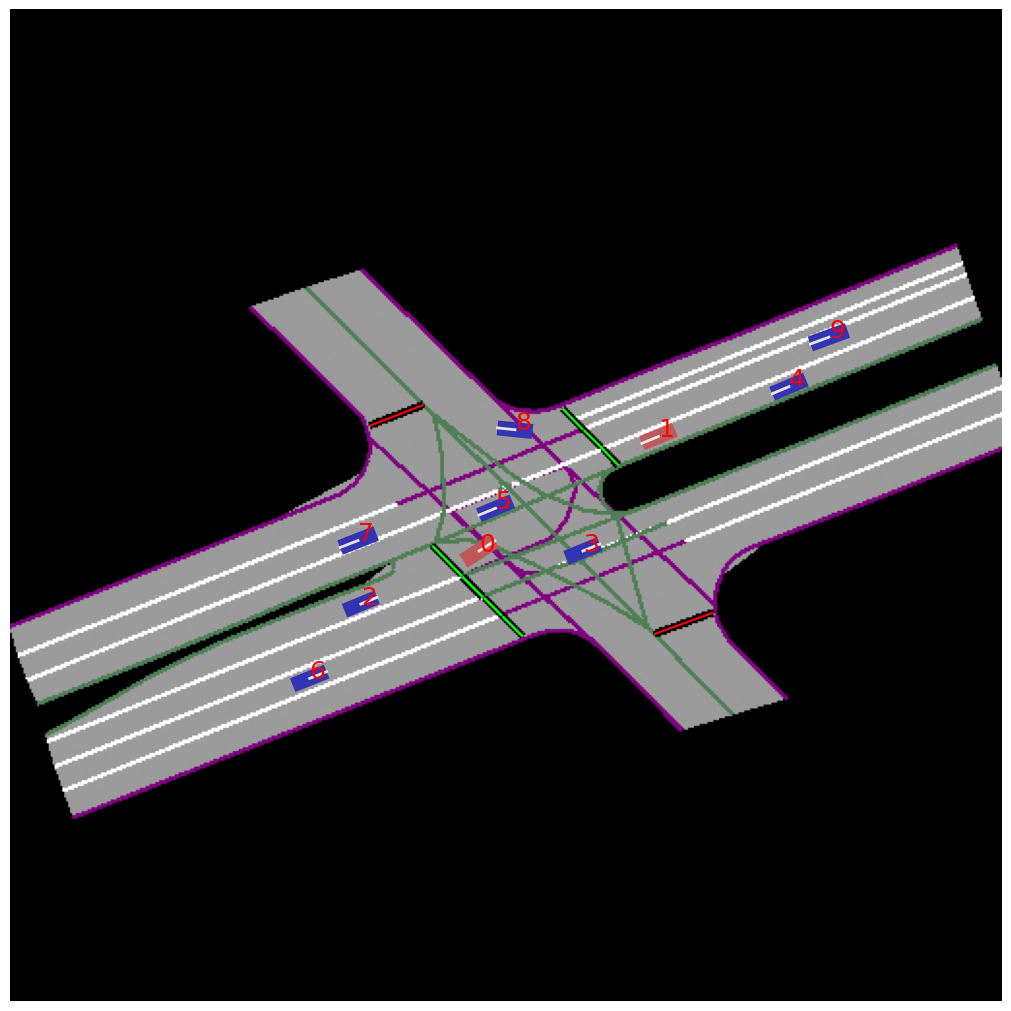

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    initial_conditions.agent_states,
    initial_conditions.agent_attributes,
    conditional_agents = [0, 1],
    traffic_light_states = traffic_light,
    ax=ax,
    numbers=True,
    velocity_vec=False,
    direction_vec=True
)

Note that the agents in blue are consistent with the agents in red we provided ourselves. This is particularly clear when looking at the velocity vectors of each of the agents. We can now run DRIVE to simulate the unprotected turn. In this example, we use DRIVE to simulate the ego vehicle, and all other vehicles. If so desired, those other vehicles could be controlled externally.

In [ ]:
agent_attributes = initial_conditions.agent_attributes
scene_plotter.initialize_recording(initial_conditions.agent_states, agent_attributes=agent_attributes, traffic_light_states=traffic_light, conditional_agents = [0, 1])
updated_state = initial_conditions;
times = []
for i in range(SIMULATION_LENGTH):
    t0 = time.time()
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        traffic_lights_states=traffic_light,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=traffic_light);
    print(f'Iteration {i}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.02 over 50 calls


Then we assemble a gif:

In [ ]:
%%capture
gif_name = 'conditional-agents.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

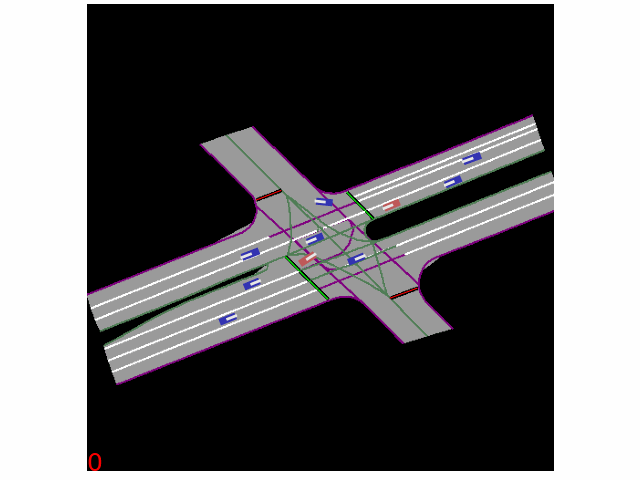

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)

Observe that the agent does not turn until the road is clear. We can clear traffic by changing the traffic light state to yellow, which will give our conditional agent an easier time to turn.

## IAI generated light states

We can now combine everything we have used so far, and walk through a flow that generates initial conditions with traffic light states generated internally by iai, and run DRIVE with that initial condition.

In [ ]:
ego_agent_state = AgentState(center=Point(x=-3.5, y=-6.0), orientation=0.57, speed=0.02)
ego_agent_attributes = AgentAttributes(length=4.9, width=2.05, rear_axis_offset=1.57)

other_agent_state = AgentState(center=Point(x=20, y=9.0), orientation=-2.75, speed=0.57)
other_agent_attributes = AgentAttributes(length=4.68, width=1.95, rear_axis_offset=1.5)

conditional_agent_states = [ego_agent_state, other_agent_state]
conditional_agent_attributes = [ego_agent_attributes, other_agent_attributes]

In [ ]:
initial_conditions = iai.initialize(
    location,
    agent_attributes = conditional_agent_attributes,
    states_history = [conditional_agent_states],
    traffic_light_state_history = None,
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 1
)

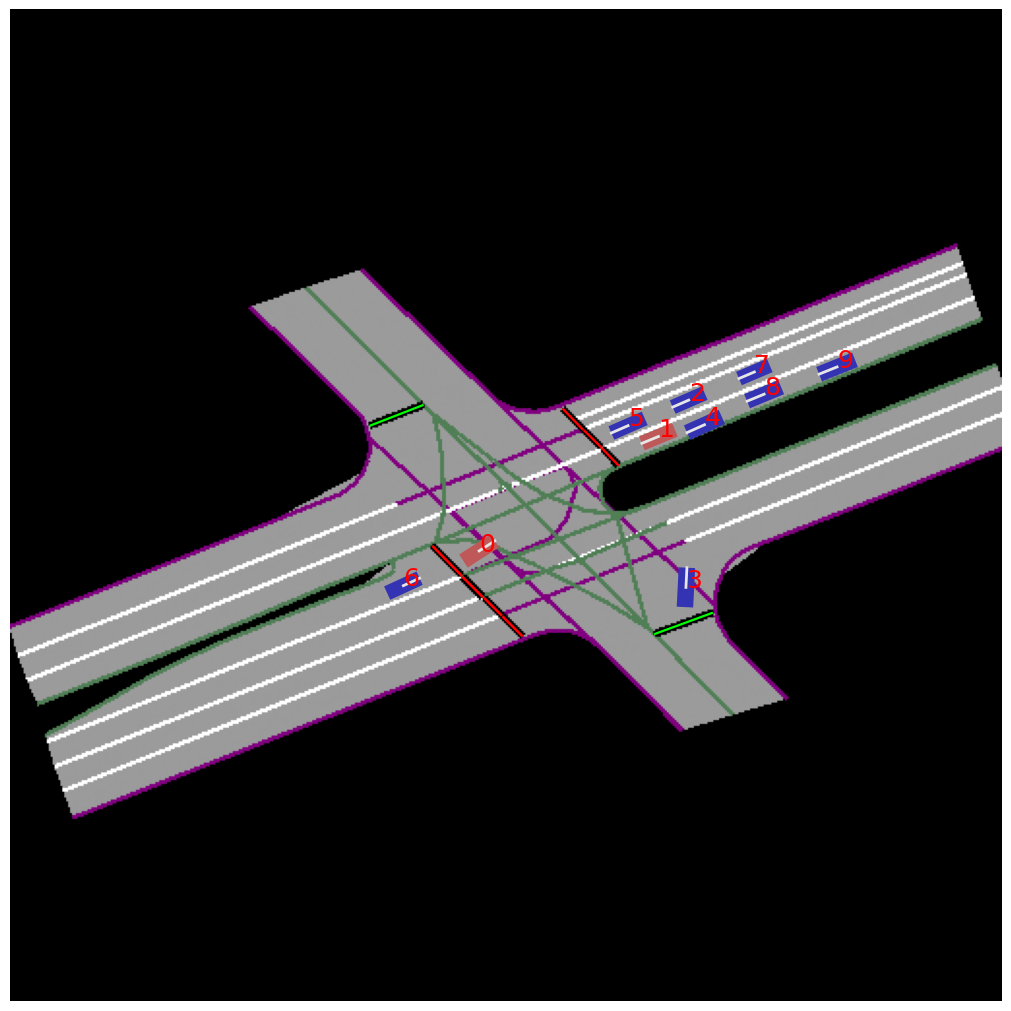

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    initial_conditions.agent_states,
    initial_conditions.agent_attributes,
    conditional_agents = [0, 1],
    traffic_light_states = initial_conditions.traffic_lights_states,
    ax=ax,
    numbers=True
)

We can now run DRIVE to simulate the rest of the scenario:

In [ ]:
agent_attributes = initial_conditions.agent_attributes

scene_plotter.initialize_recording(
    initial_conditions.agent_states,
    agent_attributes=agent_attributes,
    traffic_light_states=initial_conditions.traffic_lights_states,
    conditional_agents = [0, 1]
)
updated_state = initial_conditions
times = []
for i in range(SIMULATION_LENGTH):
    t0 = time.time()
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        light_recurrent_states=updated_state.light_recurrent_states,
        get_birdview=False,
        location=location,
        get_infractions=False,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=updated_state.traffic_lights_states);
    print(f'Iteration {i}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.02 over 50 calls


Then we assemble a gif:

In [ ]:
%%capture
gif_name = 'conditional-agents-and-lights.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

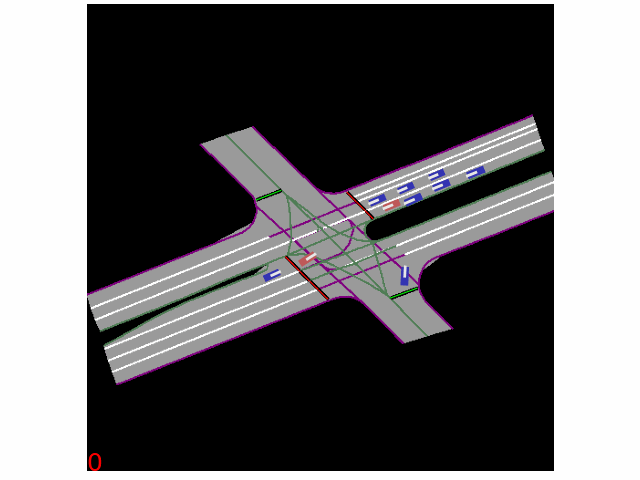

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)

## Recording infractions

The API has the ability to record infractions. Infractions should be rare, but may happen occasionally. We can trigger one by initializing a scenario that is "rigged", we set up the simulation so as to almost unavoidably rear-end our ego agent.

In [ ]:
dangerous_agent_state = AgentState(center=Point(x=-14.5, y=-11.0), orientation=0.39, speed=10.02)
dangerous_agent_attributes = AgentAttributes(length=4.9, width=2.05, rear_axis_offset=1.57)

infraction_conditional_agent_states = [ego_agent_state, other_agent_state, dangerous_agent_state]
infraction_conditional_agent_attributes = [ego_agent_attributes, other_agent_attributes, dangerous_agent_attributes]

Note that the speed of our left turning ego agent is close to zero, while the oncoming agent is going almost at full speed. Let's plot the conditional input to INITIALIZE before we make the API call, we use the same traffic lights as in the previous section. We also pass `conditional_agents` to the plotter to give the conditional agents a different color:

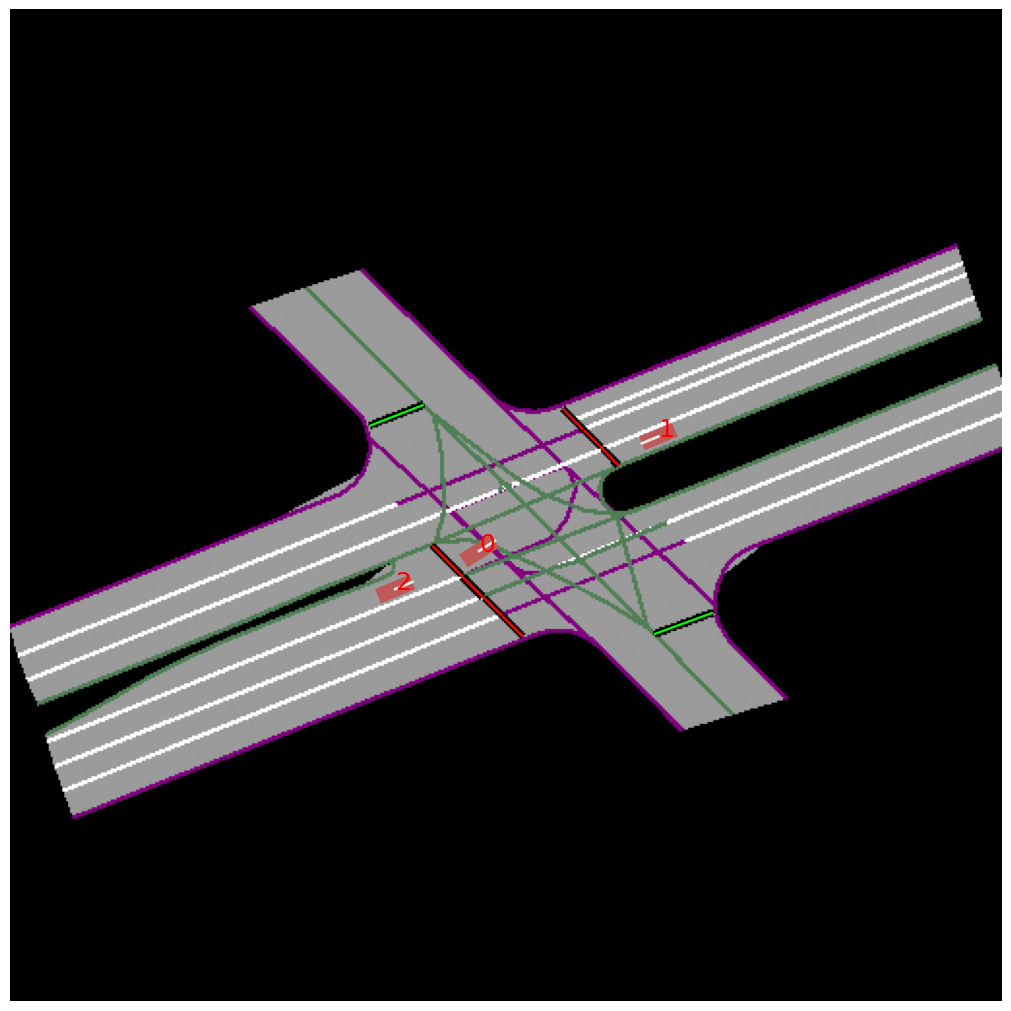

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    infraction_conditional_agent_states,
    infraction_conditional_agent_attributes,
    traffic_light_states = initial_conditions.traffic_lights_states,
    conditional_agents = [0, 1, 2],
    ax=ax,
    numbers=True
)

In [ ]:
initial_conditions = iai.initialize(
    location,
    agent_attributes = infraction_conditional_agent_attributes,
    states_history = [infraction_conditional_agent_states],
    traffic_light_state_history = [initial_conditions.traffic_lights_states],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 1
)

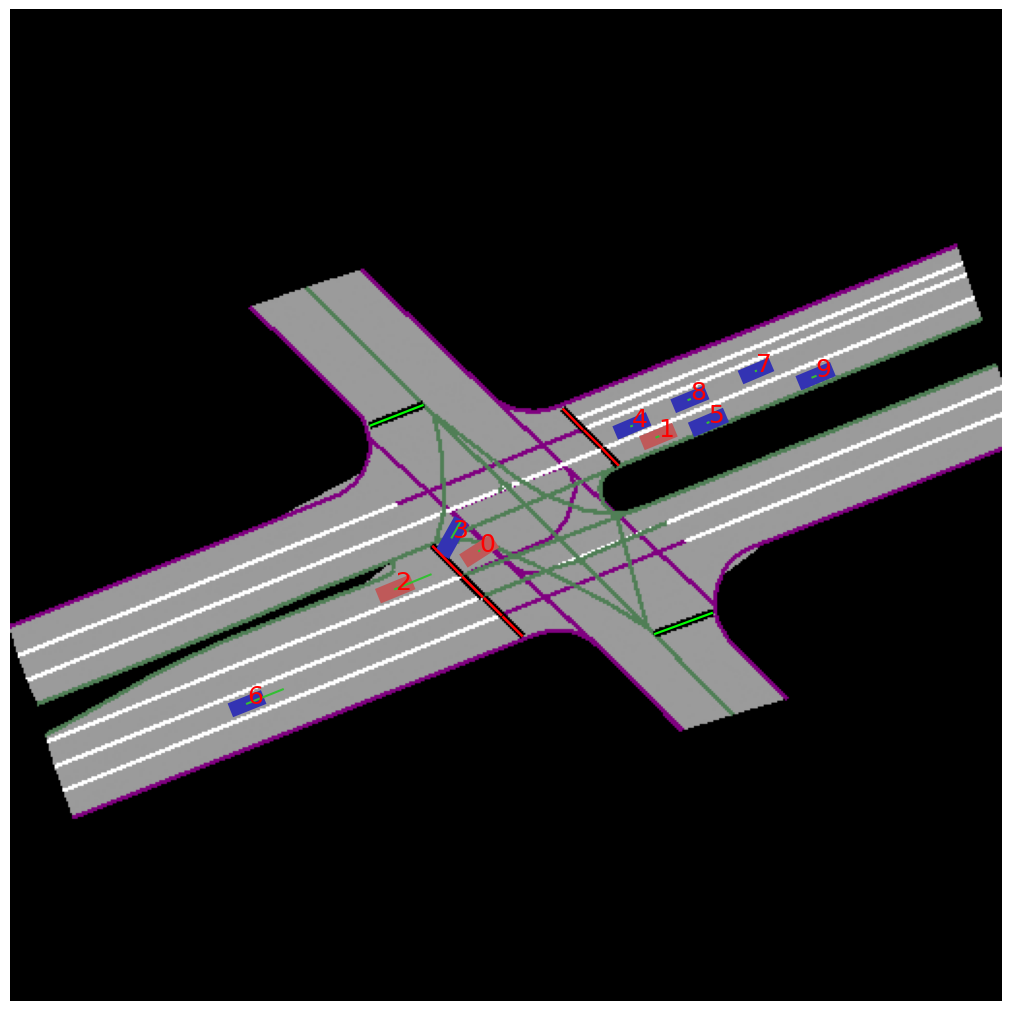

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    initial_conditions.agent_states,
    initial_conditions.agent_attributes,
    conditional_agents = [0, 1, 2],
    traffic_light_states = initial_conditions.traffic_lights_states,
    ax=ax,
    numbers=True,
    velocity_vec=True,
    direction_vec=False
)

We now simulate with drive, but we set `get_infractions` to `True`, in order to record infractions. As expected, the agent on collision course causes infractions.

In [ ]:
agent_attributes = initial_conditions.agent_attributes

scene_plotter.initialize_recording(
    initial_conditions.agent_states,
    agent_attributes=agent_attributes,
    traffic_light_states=initial_conditions.traffic_lights_states,
    conditional_agents = [0, 1, 2]
)
updated_state = initial_conditions
times = []
infractions = []
agent_of_interest = 2
for i in range(SIMULATION_LENGTH):
    t0 = time.time()
    updated_state = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=updated_state.agent_states,
        recurrent_states=updated_state.recurrent_states,
        light_recurrent_states=updated_state.light_recurrent_states,
        get_birdview=False,
        location=location,
        get_infractions=True,
    )
    t0b = time.time()
    times.append(t0b - t0)
    scene_plotter.record_step(updated_state.agent_states, traffic_light_states=updated_state.traffic_lights_states);
    infractions.append(updated_state.infractions[agent_of_interest])
    if infractions[-1].collisions or infractions[-1].offroad or infractions[-1].wrong_way:
        print(f'Agent 2 was part of an infraction in this round')
    print(f'Iteration {i}, api call time: {(times[-1]):.2f} s')
    clear_output(wait=True)
print(f'Average time per call: {sum(times)/len(times):.2f} over {len(times)} calls')

Average time per call: 0.02 over 50 calls


We can print out how often agent 2 was part of an infraction:

In [ ]:
timesteps_with_infractions = sum([1 for infraction in infractions if (infraction.collisions or infraction.offroad or infraction.wrong_way)])
print("Number of timesteps with infractions: ", timesteps_with_infractions)

Number of timesteps with infractions:  0


In [ ]:
%%capture
gif_name = 'infractions.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=False,
    direction_vec=True,
    velocity_vec=False,
    plot_frame_number=True
)

An animated gif shows the full extent of the chaos.

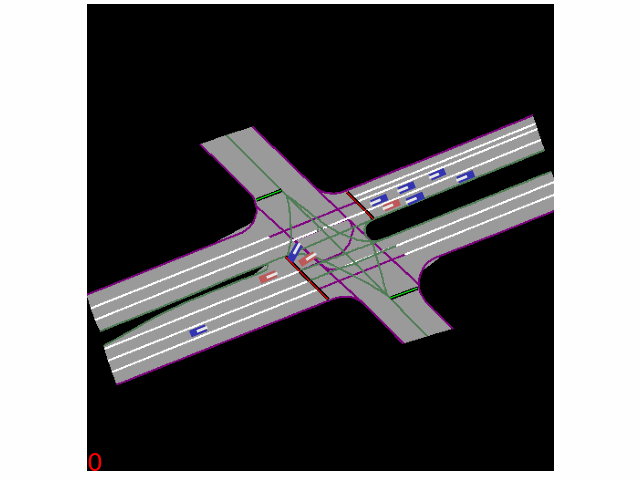

In [ ]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)

## Average infractions

This next section, we demonstrate the average amount of infractions caused over succesive rollouts from the same initial conditions, and report the overall infraction rate after. Since the number of rollouts is large, running this code will take some time in this notebook. Note that outside this notebook, this loop could easily be parallelized, effectively reducing the wait time to the that of a single rollout.

For this example, we will use INITIALIZE to generate an unconditional scenario, and roll out using LIGHT, and record if there were any infractions along the way. We report the final infraction rate.

In [ ]:
initial_conditions = iai.initialize(
    location,
    traffic_light_state_history = [initial_conditions.traffic_lights_states],
    get_birdview = False,
    get_infractions = False,
    agent_count = AGENT_COUNT,
    random_seed = 3
)

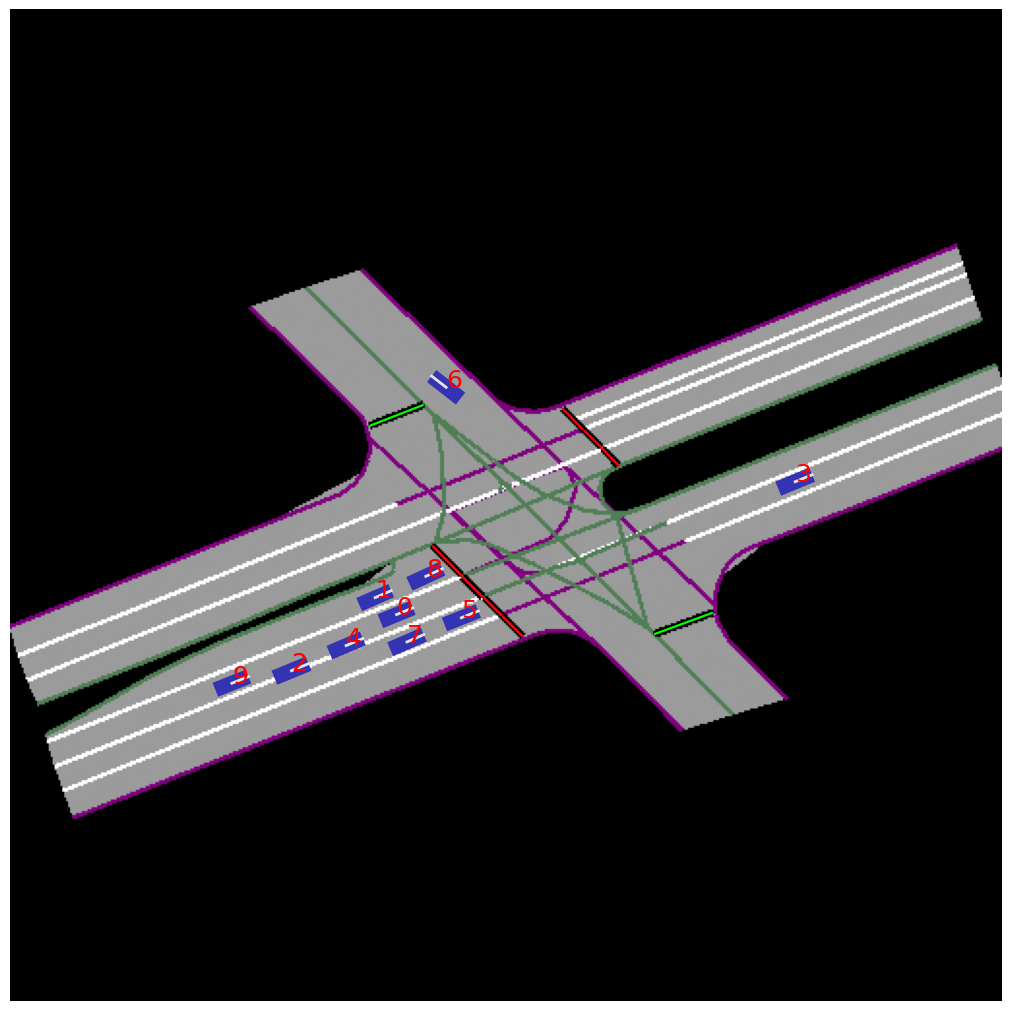

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
scene_plotter.plot_scene(
    initial_conditions.agent_states,
    initial_conditions.agent_attributes,
    traffic_light_states = initial_conditions.traffic_lights_states,
    ax=ax,
    numbers=True
)

We now run DRIVE in a nested loop, over a certain amount of trials, and report the overall infraction rate in the end. The total simulation time is 15 seconds, each starting from the same initial configuration provided by INITIALIZE in the previous step. To expedite the execution, it is possible reduce the number of trials, and get a faster (but less accurate) answer.

In [ ]:
had_infraction = {}
num_trials = 20
rollout_length = 100
for j in range(num_trials):
    had_infraction[j] = False
    agent_attributes = initial_conditions.agent_attributes
    updated_state = initial_conditions
    times = []
    for i in range(rollout_length):
        t0 = time.time()
        updated_state = iai.drive(
            agent_attributes=agent_attributes,
            agent_states=updated_state.agent_states,
            recurrent_states=updated_state.recurrent_states,
            location=location,
            light_recurrent_states=updated_state.light_recurrent_states,
            get_birdview=False,
            get_infractions=False,
            random_seed=j+1,
        )
        current_round_infractions = bool(sum([(inf.collision or inf.offroad or inf.wrong_way) for inf in updated_state.infractions])) # logical OR all infractions across all agents
        had_infraction[j] = had_infraction[j] or current_round_infractions # or with all infractions along time
        t0b = time.time()
        times.append(t0b - t0)
        print(f'Round {j+1} iteration {i+1}, api call time: {(times[-1]):.2f} s')
        clear_output(wait=True)

Round 20 iteration 100, api call time: 0.02 s


Finally, we print the overall infraction rate, averaged across the trials:

In [ ]:
overall_infraction_rate = sum([inf for inf in had_infraction.values()]) / len(had_infraction)
print(f"Overall infraction rate across {num_trials} was {overall_infraction_rate:.2f}")

Overall infraction rate across 20 was 0.00
